# Кейс №6

## Прогнозирование исходов заболевания циррозом печени с помощью ML

## Участники:

- Алёна Лозинская
- Валентина Кулакова
- Дмитрий Волобуев
- Артур Григорян
- Ильсия Коткова
- Матвей Радаев

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

/home/vvk/python/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [3]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [4]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

In [5]:
df = df[df[TARGET_COL] != 'CL'].reset_index(drop=True)

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [6]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [7]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


Числовые признаки оставим в исходном виде, поскольку ML-модели на основе случайного леса не накладывают жёстких требований в виде масштабирования, коррекции асимметрии и борьбы с выбросами. Поэтому в качестве обработки признаков закодируем только категориальные фичи:

- бинарные как 0 и 1
- Edema и Stage через OrdinalEncoder

In [8]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_

In [9]:
processor = ColumnTransformer(
    transformers=[
        ("binary", BinaryMapper(binary_maps), binary_features),
        ("category", OrdinalEncoder(), multi_category_features)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Зададим функции для построение матриц и графиков

In [11]:
#функция матрицы ошибок
def plot_confusion_matrix_simple(y_true, y_pred, title="Матрица ошибок"):
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# нарисовать дерево
def plot_tree_from_estimator(estimator, tree_step_name="ranforest"):

    if hasattr(estimator, "best_estimator_"):
        pipe = estimator.best_estimator_
    else:
        pipe = estimator

    tree_clf = pipe.named_steps[tree_step_name]
    preprocess = pipe.named_steps["preprocess"]
    feature_names = preprocess.get_feature_names_out()

    plt.figure(figsize=(24, 12), dpi=300)
    plot_tree(
        tree_clf,
        feature_names=feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True
    )
    plt.show()
# нарисовать shap
def plot_shap(best_model, X_train):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train)

    shap_values_positive = shap_values[:, :, 1]
    shap.initjs()
    shap.summary_plot(shap_values_positive, X_train)

    plt.tight_layout()
    plt.show()

    shap.summary_plot(shap_values_positive, X_train, plot_type="bar", show=False)

# Этап II. Random Forest

## 1. Создание моделей Random Forest

Создадим в цикле 4 модели, которые используют разные методы для выравнивания классов.
- Базовая модель
- Downsampling класса большинства
- Upsampling класса меньшинства
- SMOT

In [12]:
random_forest = Pipeline([
    ("preprocess", processor),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=0))
])

random_forest_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=0))
])

random_forest_os = ImbPipeline(steps=[
    ("preprocess", processor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=0))
])

random_forest_smote = ImbPipeline(steps=[
    ("preprocess", processor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=0))
])

Создание функции для подбора гиперпараметров через *optuna* и её запуска

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 78. Best value: 0.798307: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


Лучшее значение recall: 0.7983067805741552
Лучшие параметры:
ranforest__n_estimators: 43
ranforest__max_depth: 3
ranforest__min_samples_split: 16
ranforest__min_samples_leaf: 6
ranforest__max_features: sqrt
ranforest__bootstrap: True
ranforest__class_weight: balanced
ranforest__criterion: entropy
Отчёт по классам (модель Random Forest):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3972
           1       0.70      0.80      0.75      2132

    accuracy                           0.81      6104
   macro avg       0.79      0.81      0.80      6104
weighted avg       0.82      0.81      0.81      6104

Матрица ошибок для Random Forest


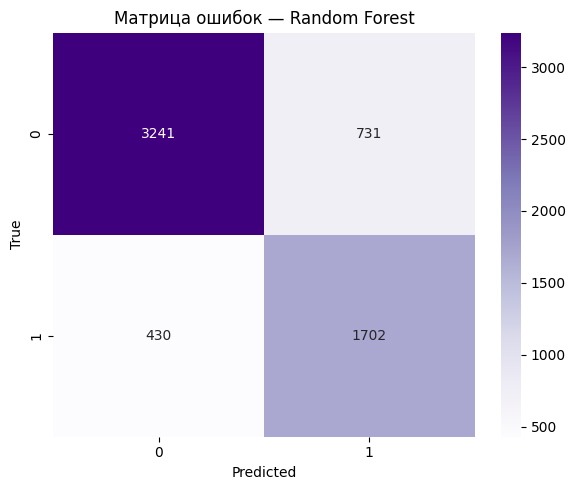

Best trial: 69. Best value: 0.816609: 100%|██████████| 100/100 [05:16<00:00,  3.16s/it]


Лучшее значение recall: 0.8166089432771493
Лучшие параметры:
ranforest__n_estimators: 170
ranforest__max_depth: 13
ranforest__min_samples_split: 7
ranforest__min_samples_leaf: 3
ranforest__max_features: sqrt
ranforest__bootstrap: True
ranforest__class_weight: balanced
ranforest__criterion: log_loss
Отчёт по классам (модель Random Forest + Downsampling):
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      3972
           1       0.73      0.82      0.77      2132

    accuracy                           0.83      6104
   macro avg       0.81      0.83      0.82      6104
weighted avg       0.84      0.83      0.83      6104

Матрица ошибок для Random Forest + Downsampling


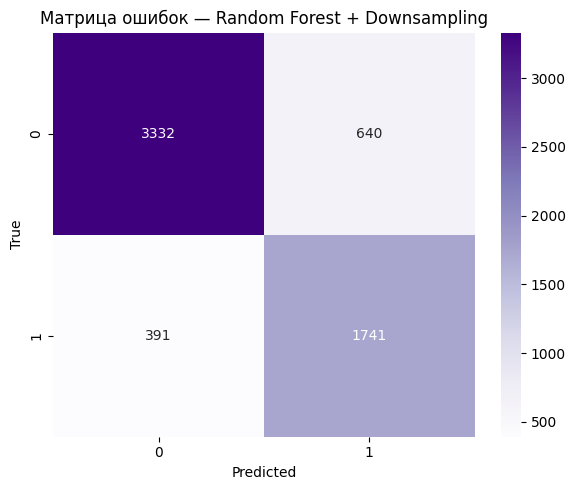

Best trial: 65. Best value: 0.802999: 100%|██████████| 100/100 [06:23<00:00,  3.84s/it]


Лучшее значение recall: 0.8029994172686393
Лучшие параметры:
ranforest__n_estimators: 83
ranforest__max_depth: 6
ranforest__min_samples_split: 14
ranforest__min_samples_leaf: 6
ranforest__max_features: None
ranforest__bootstrap: False
ranforest__class_weight: None
ranforest__criterion: entropy
Отчёт по классам (модель Random Forest + Upsampling):
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3972
           1       0.67      0.80      0.73      2132

    accuracy                           0.79      6104
   macro avg       0.78      0.80      0.78      6104
weighted avg       0.81      0.79      0.80      6104

Матрица ошибок для Random Forest + Upsampling


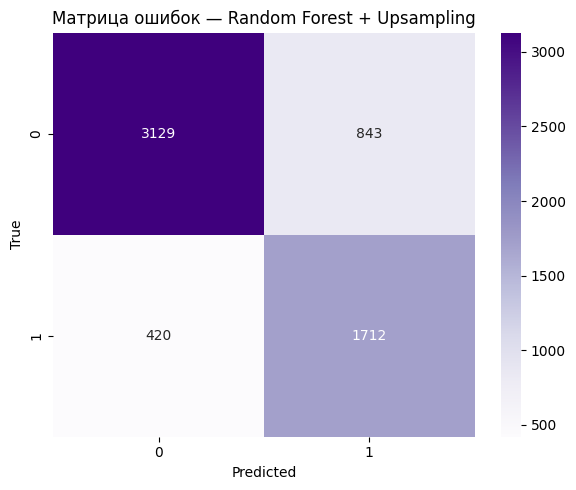

Best trial: 98. Best value: 0.781426: 100%|██████████| 100/100 [06:28<00:00,  3.88s/it]


Лучшее значение recall: 0.7814262624929906
Лучшие параметры:
ranforest__n_estimators: 103
ranforest__max_depth: 3
ranforest__min_samples_split: 11
ranforest__min_samples_leaf: 2
ranforest__max_features: log2
ranforest__bootstrap: False
ranforest__class_weight: balanced
ranforest__criterion: gini
Отчёт по классам (модель Random Forest + SMOT):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.72      0.78      0.75      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.81      0.80      6104
weighted avg       0.82      0.82      0.82      6104

Матрица ошибок для Random Forest + SMOT


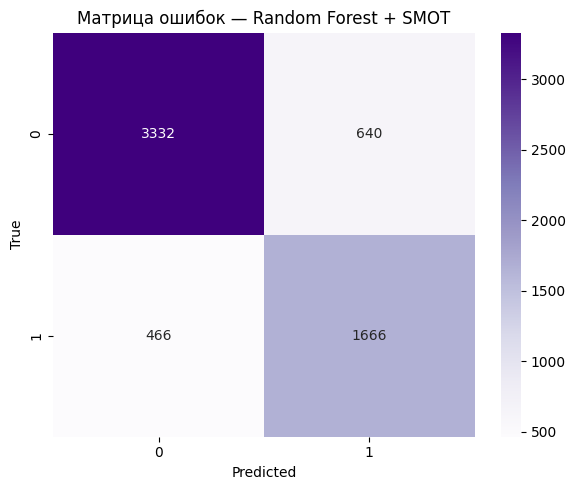

In [13]:
est_lst = [random_forest, random_forest_us, random_forest_os, random_forest_smote]
est_title = ['Random Forest', 'Random Forest + Downsampling', 'Random Forest + Upsampling', 'Random Forest + SMOT']
est_params = []

optuna.logging.set_verbosity(optuna.logging.ERROR)

for idx, est in enumerate(est_lst):
    def objective(trial):
        param_optuna = {
        'ranforest__n_estimators': trial.suggest_int('ranforest__n_estimators', 10, 300),
        'ranforest__max_depth': trial.suggest_int('ranforest__max_depth', 1, 15),
        'ranforest__min_samples_split': trial.suggest_int('ranforest__min_samples_split', 2, 20),
        'ranforest__min_samples_leaf': trial.suggest_int('ranforest__min_samples_leaf', 2, 10),
        'ranforest__max_features': trial.suggest_categorical('ranforest__max_features', [None, 'sqrt', 'log2']),
        'ranforest__bootstrap': trial.suggest_categorical('ranforest__bootstrap', [True, False]),
        'ranforest__class_weight': trial.suggest_categorical('ranforest__class_weight', [None, 'balanced']),
        'ranforest__criterion': trial.suggest_categorical('ranforest__criterion', ['gini', 'entropy', 'log_loss'])
        }
        
        random_forest_pipeline = est
        random_forest_pipeline.set_params(**param_optuna)

        scores = cross_val_score(
                    random_forest_pipeline,
                    X_train, y_train, 
                    cv=skf, 
                    scoring='recall',
                    n_jobs=-1
                )
        return np.mean(scores)

    def run_optuna_cv(n_trials):
        study = optuna.create_study(
            direction='maximize'
        )
        study.optimize(
            objective,
            n_trials=n_trials,
            n_jobs=-1,
            show_progress_bar=True,
        )

        return study
    
        
    n_trials = 100
    study = run_optuna_cv(n_trials)
    best_params = study.best_params
    best_score = study.best_value

    print(f"Лучшее значение recall: {best_score}")
    print("Лучшие параметры:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    est.set_params(**study.best_params)
    est_params.append(study.best_params)
    y_pred_rf = cross_val_predict(
        est,
        X_train, y_train,
        cv=skf,
        n_jobs=-1,
    )
    
    print(f"Отчёт по классам (модель {est_title[idx]}):")
    print(classification_report(y_train, y_pred_rf))
    print(f'Матрица ошибок для {est_title[idx]}')
    plot_confusion_matrix_simple(y_train, y_pred_rf, title=f"Матрица ошибок — {est_title[idx]}")
    print()

Лучшей по recall показала модель *Random Forest + Downsampling* с метриками:
- recall = 0.82
- precision = 0.73

Построим график распределения признаков по мере их влияния на предсказание положительного класса.

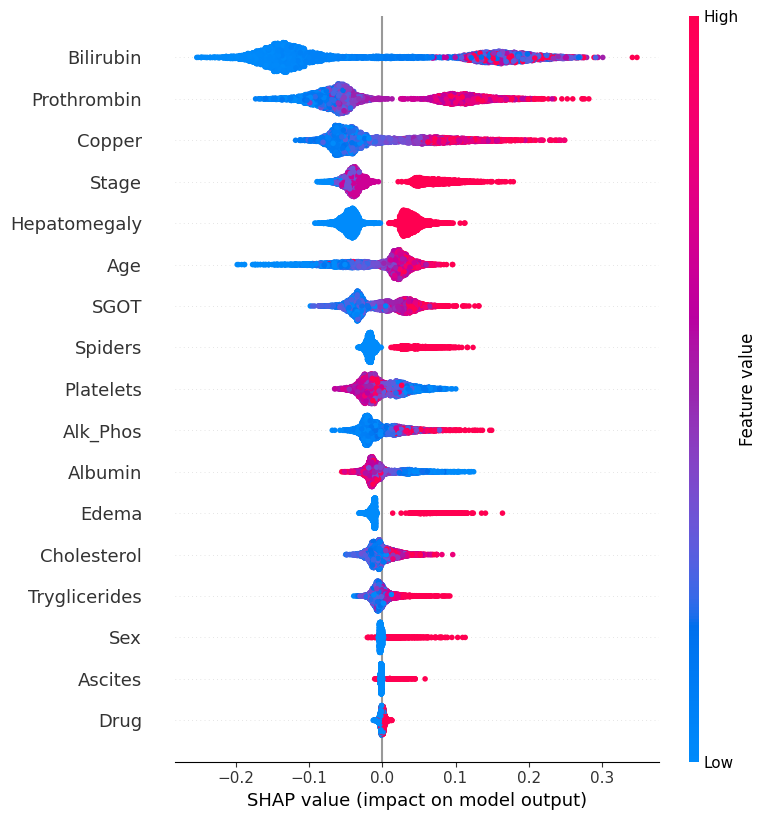

<Figure size 640x480 with 0 Axes>

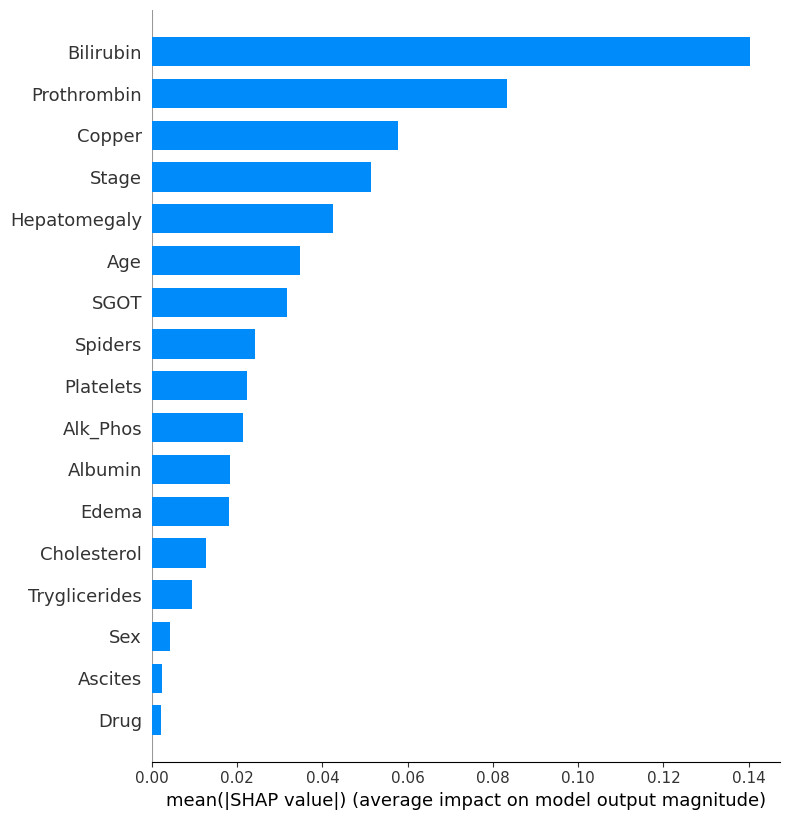

In [ ]:
idx_model = 1 #модель Random Forest + Downsampling
best_pipeline = est_lst[idx_model]
best_pipeline.set_params(**est_params[idx_model])
best_pipeline.fit(X_train, y_train)
best_model = best_pipeline.named_steps['ranforest']

processor.fit(X_train)
X_train_transformed = processor.transform(X_train)
X_train_df = pd.DataFrame(X_train_transformed, columns=processor.get_feature_names_out())

plot_shap(best_model, X_train_df)

Наибольший вклад в определение класса вносят признаки *Bilirubin*, *Prothrombin*, *Copper*, *Stage*, *Hepatomegaly*.

## 2. Feature Engineering

Возьмём снегерированные признаки из деревьев решений.

In [15]:
class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Symptom_Score - суммарное кол-во осложнений (Ascites, Hepatomegaly, Spiders, Edema)
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        mapping = {'N': 0, 'Y': 1, 'S': 1}

        ascites = X['Ascites'].map(mapping)
        hepatomegaly = X['Hepatomegaly'].map(mapping)
        spiders = X['Spiders'].map(mapping)
        edema = X['Edema'].map(mapping)

        X['Symptom_Score'] = ascites + hepatomegaly + spiders + edema
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        input_features = list(input_features)
        return np.array(input_features + ["Symptom_Score"], dtype=object)


class BilirubinAlbuminRatioTransformer(BaseEstimator, TransformerMixin):
    """
    Bilirubin_Albumin_Ratio = Bilirubin / Albumin
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Bilirubin_Albumin_Ratio'] = X['Bilirubin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Bilirubin_Albumin_Ratio"], dtype=object)
    

class CoagulationIndexTransformer(BaseEstimator, TransformerMixin):
    """
    Coagulation_Index = Prothrombin / Albumin (показатель синтетической функции печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Coagulation_Index'] = X['Prothrombin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Coagulation_Index"], dtype=object)
    

class EnzymePatternTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет Enzyme_Pattern = SGOT / Alk_Phos (тип поражения печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Enzyme_Pattern'] = X['SGOT'] / (X['Alk_Phos'] + eps)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Enzyme_Pattern"], dtype=object)

Best trial: 42. Best value: 0.790813: 100%|██████████| 100/100 [04:40<00:00,  2.80s/it]


Лучшее значение recall: 0.7908126353750922
Лучшие параметры:
ranforest__n_estimators: 296
ranforest__max_depth: 6
ranforest__min_samples_split: 3
ranforest__min_samples_leaf: 9
ranforest__max_features: sqrt
ranforest__bootstrap: False
ranforest__class_weight: balanced
ranforest__criterion: gini
Отчёт по классам (модель Random Forest + Downsampling + Feature Engineering):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.79      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.82      0.81      6104
weighted avg       0.83      0.82      0.82      6104

Матрица ошибок для Random Forest + Downsampling + Feature Engineering


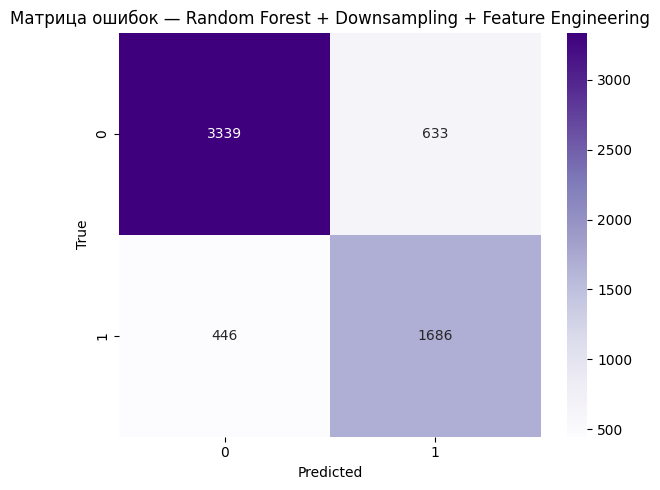

In [16]:
fe_preprocessor = Pipeline([
    ("symptom_score", SymptomScoreTransformer()),
    ("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()),
    ("coagulation_index", CoagulationIndexTransformer()),
    ("enzyme_pattern", EnzymePatternTransformer()),
    ("encode", ColumnTransformer(
        transformers=[
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OrdinalEncoder(), multi_category_features)
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    ))
])

decision_tree_fe = Pipeline([
    ("preprocess", fe_preprocessor),
    ("ranforest", RandomForestClassifier(random_state=RANDOM_STATE))])

est_lst_fe = [decision_tree_fe]
est_title_fe = ['Random Forest + Downsampling + Feature Engineering']
est_params_fe = []
n_trials = 100

optuna.logging.set_verbosity(optuna.logging.ERROR)
for idx, est in enumerate(est_lst_fe):
    def objective(trial):
        param_optuna = {
        'ranforest__n_estimators': trial.suggest_int('ranforest__n_estimators', 10, 300),
        'ranforest__max_depth': trial.suggest_int('ranforest__max_depth', 1, 15),
        'ranforest__min_samples_split': trial.suggest_int('ranforest__min_samples_split', 2, 20),
        'ranforest__min_samples_leaf': trial.suggest_int('ranforest__min_samples_leaf', 2, 10),
        'ranforest__max_features': trial.suggest_categorical('ranforest__max_features', [None, 'sqrt', 'log2']),
        'ranforest__bootstrap': trial.suggest_categorical('ranforest__bootstrap', [True, False]),
        'ranforest__class_weight': trial.suggest_categorical('ranforest__class_weight', [None, 'balanced']),
        'ranforest__criterion': trial.suggest_categorical('ranforest__criterion', ['gini', 'entropy', 'log_loss'])
        }
        
        random_forest_pipeline = est
        random_forest_pipeline.set_params(**param_optuna)

        scores = cross_val_score(
                    random_forest_pipeline,
                    X_train, y_train, 
                    cv=skf, 
                    scoring='recall',
                    n_jobs=-1
                )
        return np.mean(scores)

    def run_optuna_cv(n_trials):
        study = optuna.create_study(
            direction='maximize'
        )
        study.optimize(
            objective,
            n_trials=n_trials,
            n_jobs=-1,
            show_progress_bar=True,
        )

        return study
    
        
    study = run_optuna_cv(n_trials)
    best_params = study.best_params
    best_score = study.best_value

    print(f"Лучшее значение recall: {best_score}")
    print("Лучшие параметры:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    est.set_params(**study.best_params)
    est_params_fe.append(study.best_params)
    y_pred_rf = cross_val_predict(
        est,
        X_train, y_train,
        cv=skf,
        n_jobs=-1,
    )
    
    print(f"Отчёт по классам (модель {est_title_fe[idx]}):")
    print(classification_report(y_train, y_pred_rf))
    print(f'Матрица ошибок для {est_title_fe[idx]}')
    plot_confusion_matrix_simple(y_train, y_pred_rf, title=f"Матрица ошибок — {est_title_fe[idx]}")
    print()

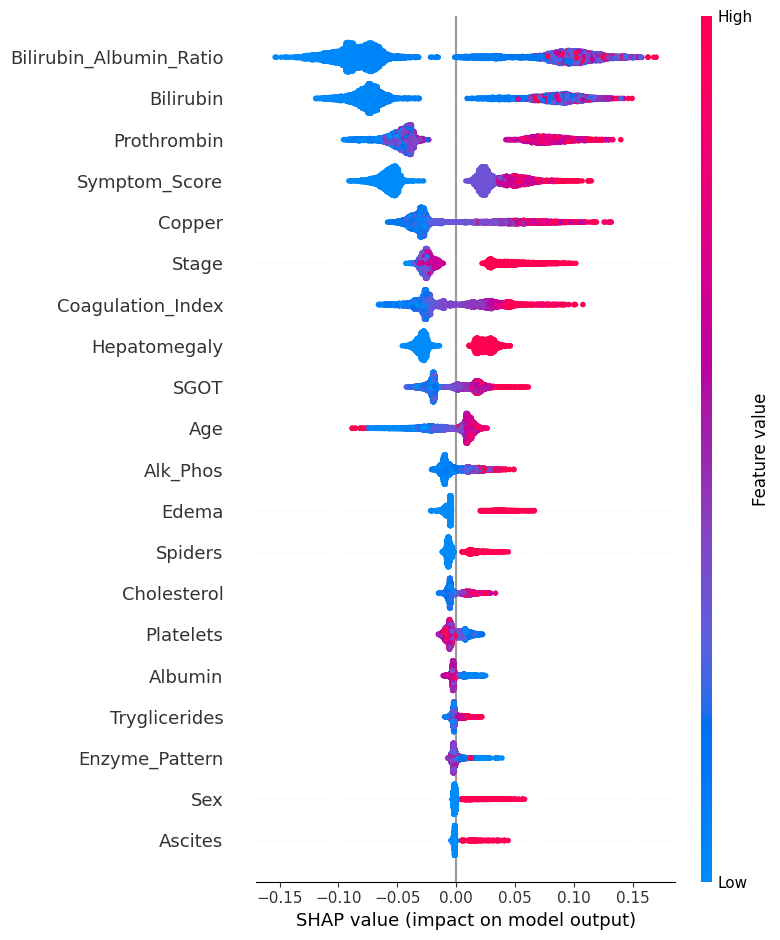

<Figure size 640x480 with 0 Axes>

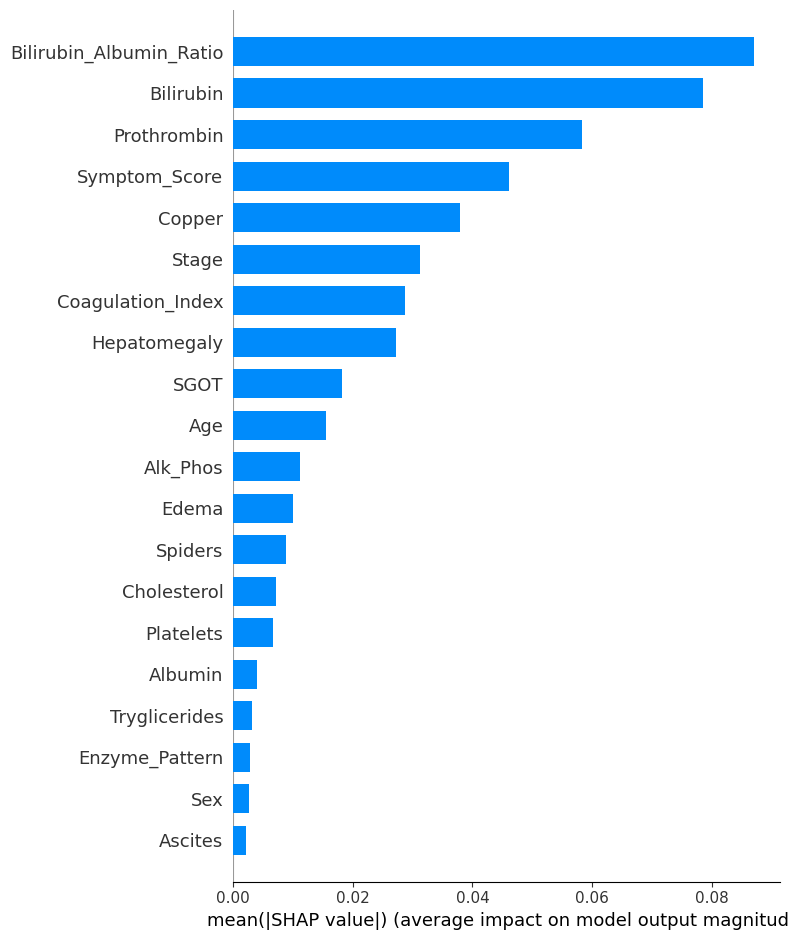

In [17]:
idx_model = 0
best_pipeline = est_lst_fe[idx_model]
best_pipeline.set_params(**est_params_fe[idx_model])
best_pipeline.fit(X_train, y_train)
best_model = best_pipeline.named_steps['ranforest']

fe_preprocessor.fit(X_train)
X_train_transformed = fe_preprocessor.transform(X_train)
X_train_df = pd.DataFrame(X_train_transformed, columns=fe_preprocessor.get_feature_names_out())

plot_shap(best_model, X_train_df)

Модель имеет чуть худший результат по метрикам по сравнению с моделью с исходными признаками. На графике важности признаков видим, что наибольшее влияние на принятие решение о классе имеют признаки *Bilirubin_Albumin_Ratio*, *Prothrombin*, *Bilirubin*.

# Этап III. Проверка на тесте

In [18]:
idx_model = 1
best_params = est_params[idx_model]
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'ranforest__n_estimators': 170, 'ranforest__max_depth': 13, 'ranforest__min_samples_split': 7, 'ranforest__min_samples_leaf': 3, 'ranforest__max_features': 'sqrt', 'ranforest__bootstrap': True, 'ranforest__class_weight': 'balanced', 'ranforest__criterion': 'log_loss'}


In [19]:
final_pipeline = est_lst[idx_model]
final_pipeline.set_params(**est_params[idx_model])
final_pipeline.fit(X_train, y_train)
best_model = best_pipeline.named_steps['ranforest']

In [20]:
y_predict_test = final_pipeline.predict(X_test)

In [21]:
print(f"Отчёт по классам на тесте:")
print(classification_report(y_test, y_predict_test))

Отчёт по классам на тесте:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       993
           1       0.70      0.81      0.75       533

    accuracy                           0.81      1526
   macro avg       0.79      0.81      0.80      1526
weighted avg       0.82      0.81      0.82      1526



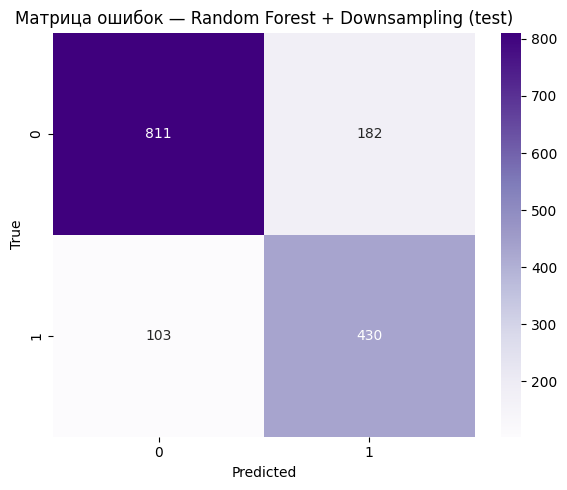

In [22]:
plot_confusion_matrix_simple(y_test, y_predict_test,
                             title="Матрица ошибок — Random Forest + Downsampling (test)")

### Выводы:

1. Лучшей среди всех моделей показала модель *Random Forest + Downsampling* по метрике recall = 0.82.
2. По сравнению с базовой моделью Дерево решений метрика чуть хуже 0.82 -> 0.85, но значительно вырос precision 0.73 -> 0.58.
3. При моделировании были использованы различные методы по борьбе с дисбалансом классов, а также использовалась генерация новых признаков, которая показала неплохие результаты.
4. Использовался метод shap для отображения важности признаков при расчёте вероятности для отнесения объекта к классу 1. Он показал, что лишь маленькое число признаков вносят значительный вклад в принятие решений.
5. Возможно для улучшения метрик следует использовать градиентный бустинг над Random Forest и провести оптимизацию гиперпараметров.